# Portfolio Optimization using Clustering & Modern Portfolio Theory

This notebook explores a basic methodology for building diversified and risk-aware portfolios by combining:
- Unsupervised learning techniques (KMeans, Hierarchical Clustering)
- Modern Portfolio Theory (MPT) for optimal asset weighting
- Manual and Automated backtesting using `bt`


## Overview:

I begin by collecting 2 years of historical data (2020–2022) for Dow Jones Industrial Average (DJIA) stocks. Using the annualized return and volatility for each stock, I apply two clustering techniques — **KMeans** and **correlation-based hierarchical clustering** — to group similar stocks together.

From each cluster, I select one representative stock to form a diversified mini-portfolio. I then apply two different weighting approaches to these portfolios:

1. **Equal weighting** – naive diversification  
2. **Modern Portfolio Theory (MPT)** – optimized for maximum Sharpe ratio

Finally, I simulate a **buy-and-hold strategy** over the next two years (2022–2025), backtesting the performance of each portfolio. These are evaluated and compared to a passive benchmark: the **S&P 500 Index**, over the same investment horizon.





---

## Key Ideas

### Modern Portfolio Theory (MPT)
MPT, introduced by Harry Markowitz, is a quantitative framework for constructing an optimal portfolio. It balances risk and return using:
- **Expected Return**: Weighted average of individual asset returns
- **Portfolio Variance**: A measure of risk, taking into account individual volatilities and covariances
- **Sharpe Ratio**: Return per unit of risk; the goal is to maximize this subject to certain constraints on the weights of the assets in the portfolio 

MPT generates the **Efficient Frontier** — a curve showing the best possible risk-return combinations. Portfolios on this frontier are optimal; those below are suboptimal.

---

### Unsupervised Learning for Portfolio Diversification
We use **clustering** to group similar stocks together. This allows us to build portfolios with exposure to diverse stock behaviors.

#### 1. KMeans Clustering
- Groups stocks based on **return and volatility**
- Assumes spherical clusters (centroid-based)
- Fast and easy to interpret

#### 2. Hierarchical Clustering (Ward's method)
- Groups stocks by **correlation distance**
- Builds a dendrogram (tree of similarity)
- Useful for discovering latent relationships between stocks

We then select **1 stock per cluster** to create diversified portfolios.

---

### Yahoo Finance via `yfinance`
We fetch price data using the `yfinance` API, which accesses Yahoo Finance data. It provides:
- Historical price data (Close, Adj Close, etc.)
- Easy access to market tickers (e.g. DJIA components)
- Reliable source for backtesting

---

### Backtesting and Evaluation

We apply two types of backtesting to evaluate the constructed portfolios:

#### 1. Manual Backtesting
In this approach, we calculate performance metrics such as:
- Cumulative Return
- Annualized Volatility
- Sharpe Ratio
- Max Drawdown

These metrics are computed using historical returns derived directly from price data. This method provides high transparency and helps assess strategy performance in a straightforward, analytical way.

#### 2. Automated Backtesting with `bt`
The `bt` library enables us to simulate a real-world investment scenario by creating strategies that include:
- Rebalancing frequency (e.g., monthly)
- Portfolio weight application (equal or optimized)
- Transaction simulation over time

This allows us to:
- Visualize the evolution of portfolio value
- Compare multiple strategies in a controlled framework
- Evaluate live performance including dynamic rebalancing

We also include a benchmark (S&P 500) to contextualize relative performance.
We compare strategies using:
- **Manual performance metrics** (Sharpe Ratio, volatility)
- **Automated backtests using `bt`** with monthly rebalancing
- **Benchmarking** against the S&P 500

Key Metrics:
- Cumulative Return
- Volatility (std dev)
- Sharpe Ratio
- Max Drawdown

---

> This notebook demonstrates how combining financial theory with machine learning can lead to smarter, more structured investment strategies.

---


### Part 1: Data Collection and Feature Engineering

In this section, I begin by installing and importing the required Python libraries for data retrieval, preprocessing, clustering, optimization, and backtesting.

I then define the universe of stocks by extracting the 30 components of the Dow Jones Industrial Average (DJIA) from Wikipedia. Using the `yfinance` API, I download 2 years of historical closing price data for these stocks.

Next, I compute daily returns and transform them into annualized return and volatility figures. These two metrics will serve as features for clustering stocks based on their risk-return characteristics.


In [1]:
!pip install yfinance

In [2]:
!pip install PyPortfolioOpt bt

In [3]:
# Import Libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform 
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import sample_cov
from pypfopt.plotting import plot_efficient_frontier
import bt



In [4]:
# Download Dow Jones Components
# We get a list of DJIA stocks from Wikipedia

# Scrape the table of Dow Jones stocks from Wikipedia
dji = pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')[2]
dji = dji[['Company', 'Symbol']]
symbols = dji['Symbol'].tolist()

In [5]:
# Download Historical Price Data (2 years)
# We'll use 'Close' prices to compute returns and volatility

data = yf.download(symbols, start = '2020-01-01', end = '2022-12-31')['Close']
# we can remove the date column for easier idnexing
data.reset_index(inplace= True)
data.drop('Date', axis = 1, inplace = True)
data.head(5)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  30 of 30 completed


Ticker,AAPL,AMGN,AMZN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,...,MSFT,NKE,NVDA,PG,SHW,TRV,UNH,V,VZ,WMT
0,72.716057,204.452911,94.900497,117.618538,331.348572,134.388794,166.062485,41.455700,96.158691,146.391541,...,153.323257,96.001976,5.972162,108.419876,181.935883,122.523209,270.618561,184.177383,45.527325,36.681847
1,72.009132,203.064911,93.748497,116.450279,330.791901,132.522919,165.247025,40.779335,95.826103,144.712265,...,151.414108,95.738960,5.876572,107.690697,179.581528,122.086632,267.880035,182.712631,45.042591,36.358017
2,72.582893,204.623245,95.143997,115.945618,331.766083,132.433624,172.486603,40.924881,95.501427,143.872635,...,151.805466,95.654419,5.901216,107.840034,179.250626,122.220276,269.739563,182.317535,44.945648,36.283993
3,72.241554,202.698761,95.343002,115.338120,335.285156,130.683853,175.022415,40.659473,94.281921,143.922043,...,150.421371,95.607437,5.972659,107.172348,178.280304,120.429329,268.111298,181.835678,44.446007,35.947842
4,73.403648,202.852036,94.598503,117.328781,329.410095,131.844406,176.345032,40.685150,93.204964,143.625687,...,152.817337,95.391434,5.983861,107.629204,181.118240,121.721313,273.764191,184.948349,44.528023,35.824474


In [6]:
# Compute Daily Returns and Annual Metrics
daily_returns = data.pct_change().dropna()
annual_mean_returns = daily_returns.mean() * 252
annual_volatility = daily_returns.var() * 252

In [7]:
# Create Feature Set for Clustering
features = pd.DataFrame()

features = pd.DataFrame({
    'Annual Return': annual_mean_returns,
    'Volatility': annual_volatility
})

features.reset_index(inplace = True)
features.head(5)

,Ticker,Annual Return,Volatility
0,AAPL,0.258011,0.136407
1,AMGN,0.098306,0.078020
2,AMZN,0.035559,0.152759
3,AXP,0.167443,0.205679
4,BA,0.000731,0.370854


### Part 2: KMeans Clustering for Portfolio Diversification

Now that I’ve created a dataset of annualized return and volatility for each stock, I apply **KMeans clustering** to group stocks with similar risk-return profiles. This helps identify diverse sets of stocks that behave differently — a foundation for building a diversified portfolio.

#### Step Breakdown:
- I first use the **Elbow Method** to determine the optimal number of clusters (k).
- Based on the curve, I select **k=6** clusters for segmentation.
- I then visualize the average annual return and volatility of each cluster.
- Finally, I select **1 representative stock per cluster**, assuming it captures the behavior of that group.

This method ensures that my final portfolio includes a variety of risk-return profiles, rather than overloading on stocks with similar behavior.


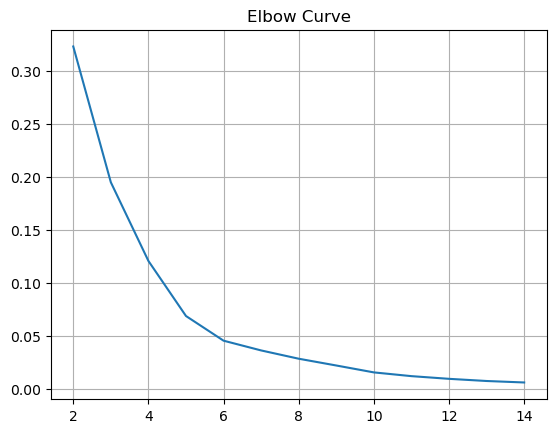

In [8]:
# Determine the optimal number of clusters using the Elbow Method
# For k values from 2 to 14, fit KMeans and record the Within-Cluster Sum of Squares (inertia).
# The 'elbow' point in the plot suggests the best number of clusters — where adding more clusters 
# yields diminishing returns in reducing inertia.

wsse = []
for k in range(2,15):
    kmeans = KMeans(n_clusters = k, n_init = 10)
    kmeans.fit(features[['Annual Return', 'Volatility']])
    wsse.append(kmeans.inertia_)

plt.plot(range(2,15), wsse)
plt.title("Elbow Curve")
plt.grid(True)


               Annual Return  Volatility
KMeans Labels                           
0                   0.223694    0.137874
1                  -0.080015    0.091139
2                   0.046576    0.163554
3                   0.455077    0.313340
4                   0.117463    0.085593
5                   0.000731    0.370854


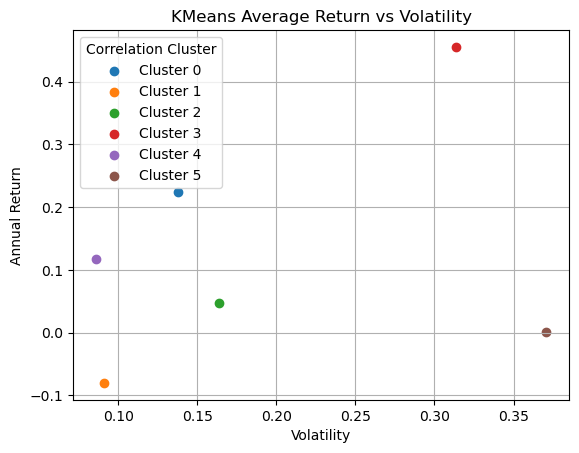

In [9]:
# Apply KMeans Clustering to Stocks
kmeans = KMeans(n_clusters=6, n_init=10, random_state=42)
kmeans.fit(features[['Annual Return', 'Volatility']])
features['KMeans Labels'] = kmeans.labels_

# Plotting average Risk-Return for each cluster
clust_info = features.groupby('KMeans Labels')[['Annual Return', 'Volatility']].mean()

print(clust_info)

for cluster in clust_info.index:
    plt.scatter(clust_info.loc[cluster,'Volatility'], clust_info.loc[cluster,'Annual Return'], label = f'Cluster {cluster}')

plt.xlabel('Volatility')
plt.ylabel('Annual Return')
plt.title('KMeans Average Return vs Volatility')
plt.legend(title='Correlation Cluster')
plt.grid(True)
plt.show()

##### Purpose of this Plot: KMeans Cluster-Wise Return vs Volatility

This scatter plot shows the **average annual return and volatility** for each KMeans cluster. Each point represents the **centroid** (mean) of one cluster — summarizing the typical risk-return profile of the stocks within that group.

Plotting this helps to:

- Understand what kind of behavior each cluster captures — for example, low-risk low-return vs high-risk high-return stocks.
- Evaluate how well the clustering aligns with financial intuition, i.e., the idea that risk and return should increase together.
- Visually inspect the diversification structure implied by KMeans: do the clusters represent distinct investment profiles?

---

##### Observations

While the Elbow Method suggested 6 clusters, the resulting cluster centroids are somewhat scattered in this space. We might expect to see a smooth upward-sloping trend (higher risk → higher return), but that pattern is not clearly reflected here.

This happens because KMeans clustering is purely geometric — it minimizes intra-cluster distance in the (return, volatility) space but doesn’t account for correlations or economic relationships. As a result, the clusters may be numerically distinct but not financially meaningful in terms of performance behavior.

In contrast, correlation-based clustering (explored in the next section) tends to produce more intuitively ordered groups based on underlying asset co-movements.



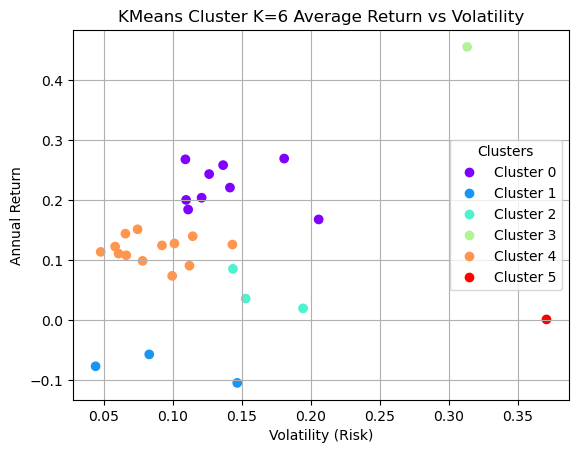

,Ticker,Annual Return,Volatility,KMeans Labels
0,AAPL,0.258011,0.136407,0
1,AMGN,0.098306,0.078020,4
2,AMZN,0.035559,0.152759,2
3,AXP,0.167443,0.205679,0
4,BA,0.000731,0.370854,5


In [10]:
# Visualising KMeans Clusters

scatter =plt.scatter(features['Volatility'], features['Annual Return'], c=kmeans.labels_, cmap = "rainbow")
plt.title('Daw Jones stocks by return and volatility , K=6')

plt.xlabel('Volatility (Risk)')
plt.ylabel('Annual Return')
plt.title('KMeans Cluster K=6 Average Return vs Volatility')
legend_labels = [f'Cluster {i}' for i in sorted(features['KMeans Labels'].unique())]
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title="Clusters", loc='best')
plt.grid(True)
plt.show()

features.head(5)

In [11]:
# Select 1 stock from each cluster to create a diversified portfolio
def kmeans_portfolio():
    stocks = []
    for i in features['KMeans Labels'].unique():
        stock = features[features['KMeans Labels'] == i].head(1)
        stocks.append(stock)
    return pd.concat(stocks)

kmeans_selected = kmeans_portfolio()
kmeans_tickers = kmeans_selected['Ticker'].tolist()
kmeans_tickers

['AAPL', 'AMGN', 'AMZN', 'BA', 'DIS', 'NVDA']

#### Observations from Clustering

- The **Elbow Curve** indicates diminishing returns in reducing inertia after k=6, supporting our choice for the number of clusters.
- In the **Average Return vs Volatility** scatter plot, each cluster demonstrates a distinct profile — some offer high return at higher risk (e.g. Cluster 3), while others are low return/low risk (e.g. Cluster 1).
- The **full clustering plot** clearly separates the DJIA stocks into 6 distinct behavioral groups.

This confirms the effectiveness of KMeans in segmenting the stock universe based on historical characteristics. By picking one stock from each cluster, we achieve exposure to a wide range of behaviors, which supports diversification.

**Selected Stocks (1 from each cluster):**

`['AAPL', 'AMGN', 'AMZN', 'BA', 'DIS', 'NVDA']`

These represent the centroids of each cluster and form the basis of the KMeans-diversified portfolio.



### Part 3: Correlation-Based Clustering with Hierarchical Methods

In this section, I implement an alternative clustering approach using **hierarchical clustering based on asset correlations**.

While KMeans clusters based on absolute levels of return and volatility, this method focuses on **how assets behave in relation to each other**. Highly correlated stocks are grouped into the same cluster, which helps reduce **redundant exposure** in a portfolio.

#### Step Breakdown:
- Compute a **correlation matrix** of all stock returns.
- Convert this to a **distance matrix** using the transformation:  
  `distance = 1 - correlation`
- Perform hierarchical clustering using the **Ward linkage** method.
- Visualize the **dendrogram** to understand the cluster formation.
- Select **1 representative stock per cluster** to construct a diversified portfolio.

This method is more reflective of market dynamics, as it groups stocks that move together and allows us to avoid overconcentration in correlated assets.


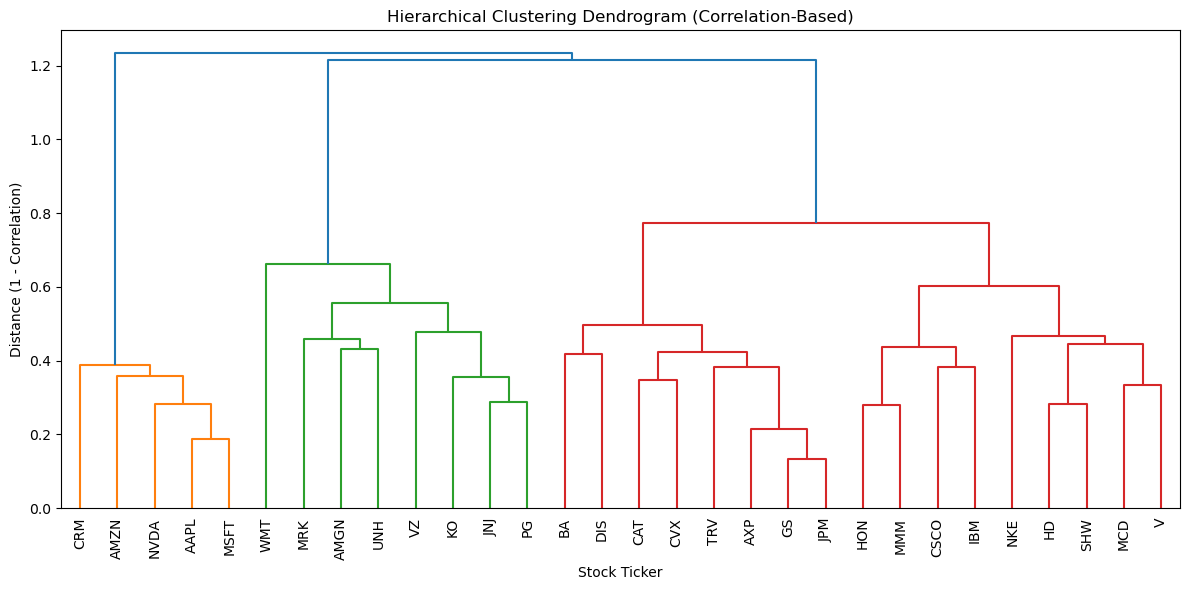

,Ticker,Annual Return,Volatility,KMeans Labels,Correlation Cluster
0,AAPL,0.258011,0.136407,0,1
1,AMGN,0.098306,0.078020,4,2
2,AMZN,0.035559,0.152759,2,1
3,AXP,0.167443,0.205679,0,3
4,BA,0.000731,0.370854,5,3


In [12]:
# Step 6: Correlation-Based Clustering using Hierarchical Methods
correlation_matrix = daily_returns.corr()

# Convert correlation matrix into distance : high correlation = low distance 
distance_matrix = 1 - correlation_matrix

# turn the symmetric matrix into a flat array - needed for linkage
condensed_dist = squareform(distance_matrix)
link = linkage(condensed_dist, method='ward')
corr_labels = fcluster(link, 0.7, criterion='distance')
features['Correlation Cluster'] = corr_labels

plt.figure(figsize=(12, 6))
dendrogram(link, labels=correlation_matrix.columns, leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram (Correlation-Based)")
plt.xlabel("Stock Ticker")
plt.ylabel("Distance (1 - Correlation)")
plt.tight_layout()
plt.show()

features.head()

                     Annual Return  Volatility
Correlation Cluster                           
1                         0.194290    0.183535
2                         0.110752    0.066141
3                         0.133071    0.178258
4                         0.108191    0.103220


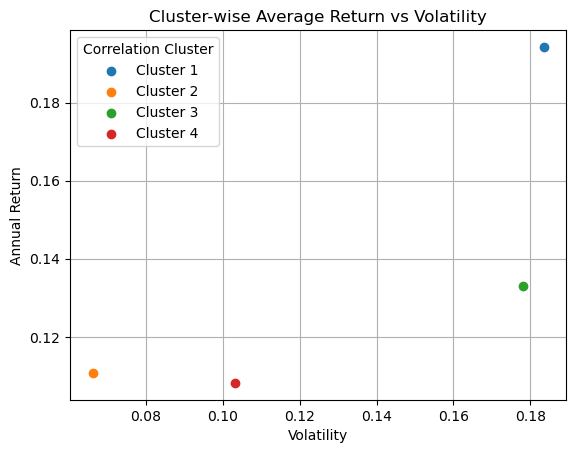

In [13]:
# Plotting average Risk-Return for each cluster
clust_info = features.groupby('Correlation Cluster')[['Annual Return', 'Volatility']].mean()

print(clust_info)

for cluster in clust_info.index:
    plt.scatter(clust_info.loc[cluster,'Volatility'], clust_info.loc[cluster,'Annual Return'], label = f'Cluster {cluster}')

plt.xlabel('Volatility')
plt.ylabel('Annual Return')
plt.title('Cluster-wise Average Return vs Volatility')
plt.legend(title='Correlation Cluster')
plt.grid(True)
plt.show()

As before, This plot displays the centroid of each correlation-based cluster, using the average annual return and volatility of all the stocks within that cluster.

##### Interpretation and Comparison to KMeans

Unlike the KMeans clusters, which appeared scattered and didn't reflect a clear risk-return progression, this correlation-based method produces a much more structured output:

- We observe an increasing trend: clusters with higher average volatility also exhibit higher average return, aligning with the core financial principle that higher risk should be compensated by higher return.
- The spacing between clusters also appears more economically intuitive — low-volatility clusters are well-separated from higher-risk, higher-return groups.
- Since these clusters are based on how stocks move together, not just individual stats, they naturally reflect market structure more than purely statistical grouping (as in KMeans).

In summary, this plot shows that correlation-based clustering produces cleaner, more interpretable groupings for building diversified portfolios — especially when our goal is to reduce co-movement and overlap in risk exposures.


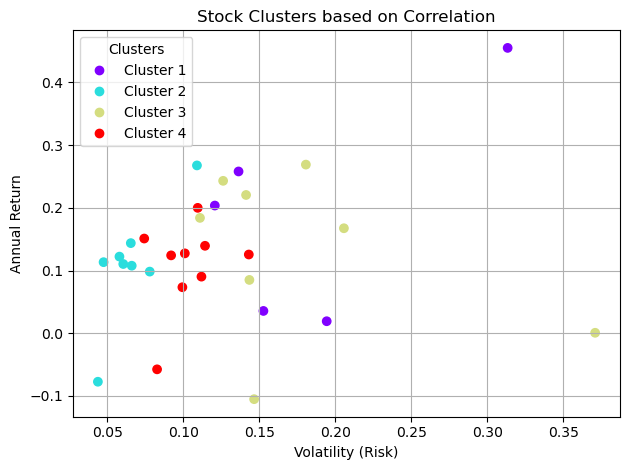

In [14]:
# Visualising Correlation Clusters
scatter = plt.scatter(features['Volatility'], features['Annual Return'], c=features['Correlation Cluster'], cmap='rainbow')

# Label the axes
plt.xlabel('Volatility (Risk)')
plt.ylabel('Annual Return')
plt.title('Stock Clusters based on Correlation')
legend_labels = [f'Cluster {i}' for i in sorted(features['Correlation Cluster'].unique())]
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title="Clusters", loc='best')

plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
# Select 1 stock from each correlation cluster
def correlation_portfolio():
    stocks = []
    for i in features['Correlation Cluster'].unique():
        stock = features[features['Correlation Cluster'] == i].head(1)
        stocks.append(stock)
    return pd.concat(stocks)

corr_selected = correlation_portfolio()
corr_tickers = corr_selected['Ticker'].tolist()
corr_tickers

['AAPL', 'AMGN', 'AXP', 'CSCO']

#### Observations from Correlation-Based Clustering

- The **dendrogram** shows clear groupings of stocks based on how tightly their returns move together.
- Using a distance threshold of 0.7, I identified 4 distinct clusters.
- In the **average return vs volatility** plot, the clusters appear better structured than in KMeans — there is a clearer upward trend from low-risk to high-risk groups.
- The **scatter plot** shows meaningful behavioral segmentation — each cluster includes stocks with similar co-movement patterns, regardless of return/volatility magnitude.

This clustering method offers stronger diversification by avoiding correlated assets. While KMeans focused on statistical distance, this method captures **financial behavior**, making it well-suited for building portfolios that are resilient to market-wide moves.

**Selected Stocks (1 per correlation-based cluster):**

`['AAPL', 'AMGN', 'AXP', 'CSCO']`

These stocks represent distinct behavioral groups and form the basis of the correlation-diversified portfolio.



### Part 4: Portfolio Construction — Equal Weighting & Return Preparation

Now that I’ve selected the final stocks from each clustering strategy (KMeans and Correlation), the next step is to prepare their price and return data for analysis.

#### Step Breakdown:
- I combine the tickers from both portfolios and download their adjusted closing prices from Yahoo Finance, starting from **2022**, which marks the beginning of the backtesting period.
- I compute **daily returns** for each stock, which will serve as the basis for both:
  - Equal-weighted portfolio simulation
  - Portfolio optimization using Modern Portfolio Theory (MPT)

This stage ensures that both strategies are evaluated **on the same investment period and price basis**, allowing for fair comparison later.


In [16]:
# Pull close prices for our portfolio stocks
tickers = list(set(kmeans_tickers + corr_tickers))
price_data = yf.download(tickers, start = '2022-01-01', end = '2025-01-01')['Close']


print(f'Selected Stocks based on Correlation Clusters : {corr_tickers}')
print(f'Selected Stocks based on KMeans Clusters : {kmeans_tickers}')

[*********************100%***********************]  8 of 8 completed

Selected Stocks based on Correlation Clusters : ['AAPL', 'AMGN', 'AXP', 'CSCO']
Selected Stocks based on KMeans Clusters : ['AAPL', 'AMGN', 'AMZN', 'BA', 'DIS', 'NVDA']


In [17]:
# Creating Equally weighted returns
returns = price_data.pct_change().dropna()
returns.head(5)

Ticker,AAPL,AMGN,AMZN,AXP,BA,CSCO,DIS,NVDA
Date,,,,,,,,
2022-01-04,-0.012692,0.005073,-0.016916,0.032103,0.027759,-0.024526,-0.006571,-0.027589
2022-01-05,-0.026600,-0.011850,-0.018893,-0.010656,-0.002621,-0.015837,-0.003467,-0.057562
2022-01-06,-0.016693,0.000133,-0.006711,0.009163,-0.008119,0.010617,0.011019,0.020794
2022-01-07,0.000988,0.009415,-0.004288,0.008560,0.019684,0.003447,0.005927,-0.033040
2022-01-10,0.000116,0.013551,-0.006570,-0.003670,-0.028724,0.011288,-0.007793,0.005615


Here, I use `.pct_change()` to calculate daily returns from price data.
These returns will be used to:
- Evaluate naïve equal-weight portfolios (no optimization)
- Serve as inputs for estimating expected return and risk in the next section using PyPortfolioOpt


In [18]:
'''

# calculating the daily average return for each portfolio
kmeans_returns = returns[kmeans_tickers].mean(axis=1)
correlation_returns = returns[corr_tickers].mean(axis=1)

# plotting the daily cumilative return for each portfolio 
(1 + kmeans_returns).cumprod().plot(label='KMeans Portfolio')
(1 + correlation_returns).cumprod().plot(label='Correlation Portfolio')
plt.title('Portfolio Growth Comparison')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()
'''

"\n\n# calculating the daily average return for each portfolio\nkmeans_returns = returns[kmeans_tickers].mean(axis=1)\ncorrelation_returns = returns[corr_tickers].mean(axis=1)\n\n# plotting the daily cumilative return for each portfolio \n(1 + kmeans_returns).cumprod().plot(label='KMeans Portfolio')\n(1 + correlation_returns).cumprod().plot(label='Correlation Portfolio')\nplt.title('Portfolio Growth Comparison')\nplt.ylabel('Cumulative Return')\nplt.xlabel('Date')\nplt.legend()\nplt.grid(True)\nplt.show()\n"

### Part 5: Portfolio Optimization using Modern Portfolio Theory (MPT)

In this section, I apply **Modern Portfolio Theory (MPT)** to the portfolios constructed from both clustering methods.

The goal is to determine the optimal allocation of weights across the selected stocks to **maximize the Sharpe Ratio** — i.e., to achieve the best possible return per unit of risk.

#### Step Breakdown:
- Estimate the **expected return (`mu`)** and **covariance matrix (`S`)** of asset returns using historical data.
- Use `PyPortfolioOpt` to solve for the **maximum Sharpe ratio portfolio**, under the constraint of long-only weights.
- Plot the **Efficient Frontier**, which shows the optimal trade-off between return and volatility.
- Identify the **Max Sharpe portfolio** (best risk-adjusted return) and the **Min Volatility portfolio** (least risky).

By comparing the optimized portfolios for KMeans and correlation-based selections, I can assess not only their raw returns but their efficiency in balancing risk and reward.


In [19]:
# Applying MPT to find optimal weights 
km_price_data = price_data[kmeans_tickers]
corr_price_data = price_data[corr_tickers]

In [20]:
#  Define a MPT function that ...
def MPT(price_data, method):

    mu = mean_historical_return(price_data)
    S = sample_cov(price_data)

    
    # Finding optimal weights that solve the maximum Sharpe ratio with weight constraints
    ef = EfficientFrontier(mu, S)
    weights = ef.max_sharpe()    
    cleaned_weights = ef.clean_weights()

    performance = ef.portfolio_performance(verbose=True)

    print('Optimised Portfolio Weights:')
    print(cleaned_weights)
    print(performance)

    #PLOTS
    # Create a fresh EfficientFrontier for plotting
    fig, ax = plt.subplots(figsize=(10,6))
    ef_plot = EfficientFrontier(mu, S)

    
    plot_efficient_frontier(ef_plot, ax=ax, show_assets=True)

    # Label individual assets
    for i, txt in enumerate(mu.index):
        x = S.loc[txt,txt] ** 0.5  
        y = mu[txt]  
        ax.annotate(txt, (x,y+0.005), fontsize = 9)

    # Max Sharpe point
    ret, risk, _  = ef.portfolio_performance()
    ax.scatter(risk, ret, marker = '*',s=100, c='r', label = 'Max Sharpe')

    # Min Vol point
    ef_min = EfficientFrontier(mu, S)
    ef_min.min_volatility()
    ret_min, risk_min, _ = ef_min.portfolio_performance()
    ax.scatter(risk_min, ret_min, marker='^', s=100, c='g', label='Min Volatility')



    ax.set_title(f'Efficient Frontier with Max Sharpe Portfolio for {method}')
    ax.legend()
    plt.grid(True)
    plt.show()

    return ret, risk, cleaned_weights 

Expected annual return: 18.4%
Annual volatility: 22.8%
Sharpe Ratio: 0.80
Optimised Portfolio Weights:
OrderedDict([('AAPL', 0.07889), ('AMGN', 0.23338), ('AXP', 0.68774), ('CSCO', 0.0)])
(0.18367592016348042, 0.22827517963151125, 0.8046250164383867)


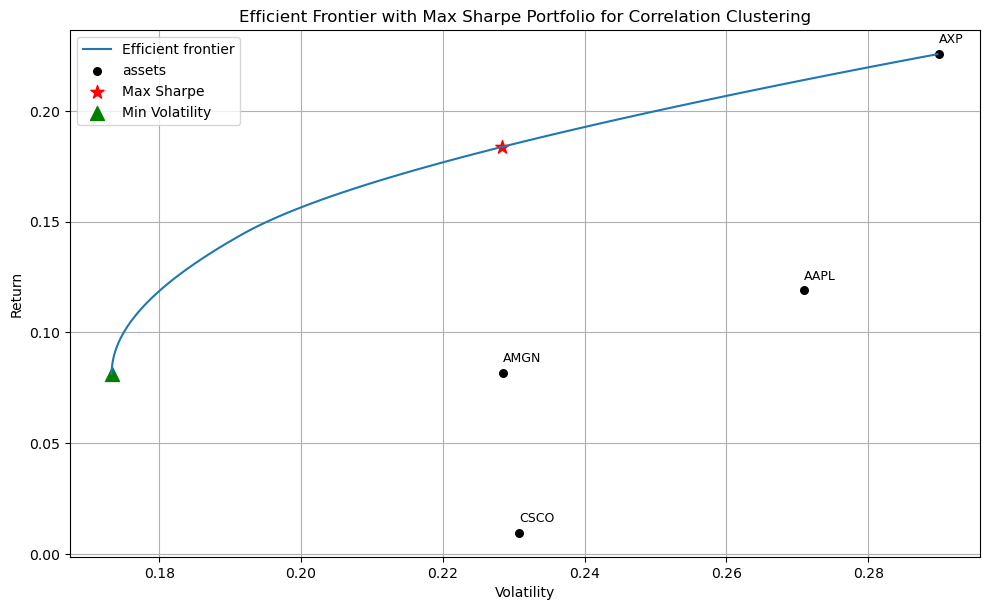

Expected annual return: 44.7%
Annual volatility: 37.0%
Sharpe Ratio: 1.21
Optimised Portfolio Weights:
OrderedDict([('AAPL', 0.0), ('AMGN', 0.35816), ('AMZN', 0.0), ('BA', 0.0), ('DIS', 0.0), ('NVDA', 0.64184)])
(0.44720695093171225, 0.3702787012030584, 1.2077576956997775)


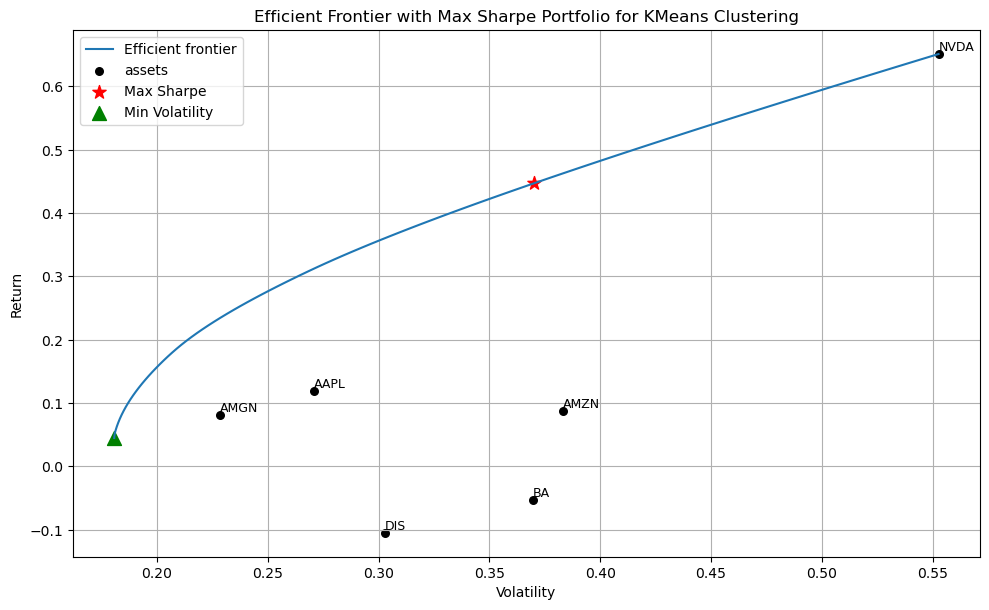

In [21]:
ret_corr, risk_corr, corr_weights = MPT(corr_price_data, 'Correlation Clustering')
ret_km, risk_km, km_weights = MPT(km_price_data, 'KMeans Clustering')

#### Observations:

- Max Sharpe Portfolio is the portfolio that offers the highest return per unit of risk 
- Min Volatility Portfolio is the portfolio with the lowest total risk (volatility)- appealing for risk-averse investors.
- Including both points helps visualize the range of trade-offs along the Efficient Frontier between Max Sharpe which is performance-focused, possibly aggressive and Min Volatility which is safety-focused, possibly conservative


##### Optimized Portfolio Performance (Correlation-Based)

- *Expected Annual Return*: 18.4%  
- *Annual Volatility*: 22.8%  
- *Sharpe Ratio*: 0.80  

The optimizer places the largest weight (~69%) on AXP, likely due to its high return and acceptable volatility. CSCO, however, receives 0% weight, suggesting poor risk-adjusted contribution.

##### Optimized Portfolio Performance (KMeans-Based)

- *Expected Annual Return*: 44.7%  
- *Annual Volatility*: 37.0%  
- *Sharpe Ratio*: 1.21  

Here, the optimizer leans heavily on NVDA, with a weight of ~64%, which has high expected return but also high volatility. DIS, AMZN, BA, and AAPL receive no allocation, which suggests either high risk or low return relative to the others.

---

##### Key Insights

- The **KMeans portfolio achieves a higher Sharpe Ratio**, but also comes with significantly higher volatility.
- The **Correlation-based portfolio is more conservative**, aligning with the goal of diversification through behavioral similarity.
- The **Efficient Frontier plots** visually highlight how both portfolios sit relative to the theoretical limit of risk-return efficiency.
- Asset labels provide transparency, allowing us to audit why the optimizer preferred certain stocks.

This step helps transform static portfolios into efficient ones, revealing how optimal allocation can dramatically shift performance — even with the same underlying assets.


### Part 6: Backtesting and Performance Analysis

Now that the portfolios have been constructed — both using **KMeans** and **Correlation-Based Clustering** — and optimized via **Modern Portfolio Theory**, the next step is to evaluate their performance through **backtesting**.

#### Step Breakdown:

1. **Define portfolio performance functions**:
   - Calculate **daily returns** and **cumulative returns** for each portfolio.
   - Compute **rolling Sharpe Ratios** to monitor changes in risk-adjusted return over time.

2. **Create baseline and comparative strategies**:
   - Benchmark returns are taken from the **S&P 500** (`^GSPC`) for context.
   - Compare both **Equal Weighting** and **Optimized Weighting** strategies.

3. **Visualize key metrics**:
   - Plot **portfolio value over time** to observe growth trajectories.
   - Plot **rolling Sharpe ratios** to assess stability and efficiency.

4. **Quantify performance**:
   - Print metrics such as **Total Return**, **Volatility**, **Mean Daily Return**, and **Sharpe Ratio**.
   - Use these to contrast the efficiency and consistency of each strategy.

We assess not only how much return each portfolio generated, but how efficiently and consistently it did so relative to market benchmarks.



In [22]:
# Define some functions to compare...

def portfolio_return(price_data, weights):
    returns = price_data.pct_change().dropna()
    weight_series = pd.Series(weights)
    daily_returns = returns @ weight_series

    #cumilative return 
    cum_returns = (1+daily_returns).cumprod()

    return cum_returns, daily_returns   # cumilative return = portfolio value, daily returns = portfolio return

def rolling_sharpe(returns, window=30):

    rolling_mean = returns.rolling(window).mean()
    rolling_std = returns.rolling(window).std()
    rolling_sharpe = rolling_mean/rolling_std #assume risk free rate is 0

    return rolling_sharpe

def analyze(returns, label):
    print(f"\n{label}")
    print(f"Total Return: {(returns + 1).prod() - 1:.2%}")
    print(f"Mean Daily Return: {returns.mean():.4f}")
    print(f"Volatility: {returns.std():.4f}")
    print(f"Sharpe Ratio (R_f = 0): {returns.mean() / returns.std():.2f}")

#Benchmark

benchmark = yf.download('^GSPC', start='2022-01-01', end='2025-01-01')['Close']
benchmark_returns = benchmark.pct_change().dropna()
benchmark_cum = (1 + benchmark_returns).cumprod()

[*********************100%***********************]  1 of 1 completed


In [23]:
# Equal Weights
from collections import OrderedDict

corr_eq_weights_list = [ 1/len(corr_tickers) for _ in range(len(corr_tickers))]
corr_eq_weights = OrderedDict(zip(corr_tickers, corr_eq_weights_list))
km_eq_weights_list = [ 1/len(kmeans_tickers) for _ in range(len(kmeans_tickers))]
km_eq_weights = OrderedDict(zip(kmeans_tickers, km_eq_weights_list))

In [24]:
# MPT weights
corr_opt_weights = corr_weights
km_opt_weights = km_weights

In [25]:
# Cumilative portfolio return and daily return for Equal Weights + Rolling Sharpe Ratio
corr_eqport_value, corr_eqport_ret = portfolio_return(corr_price_data,corr_eq_weights)
km_eqport_value, km_eqport_ret = portfolio_return(km_price_data, km_eq_weights)

corr_eqport_rolsharp = rolling_sharpe(corr_eqport_ret, window=30)
km_eqport_rolsharp = rolling_sharpe(km_eqport_ret, window=30)

# Cumilative portfolio return and daily return for Optimised Weights
corr_optport_value, corr_optport_ret = portfolio_return(corr_price_data,corr_opt_weights)
km_optport_value, km_optport_ret = portfolio_return(km_price_data, km_opt_weights)

corr_optport_rolsharp = rolling_sharpe(corr_optport_ret, window=30)
km_optport_rolsharp = rolling_sharpe(km_optport_ret, window=30)

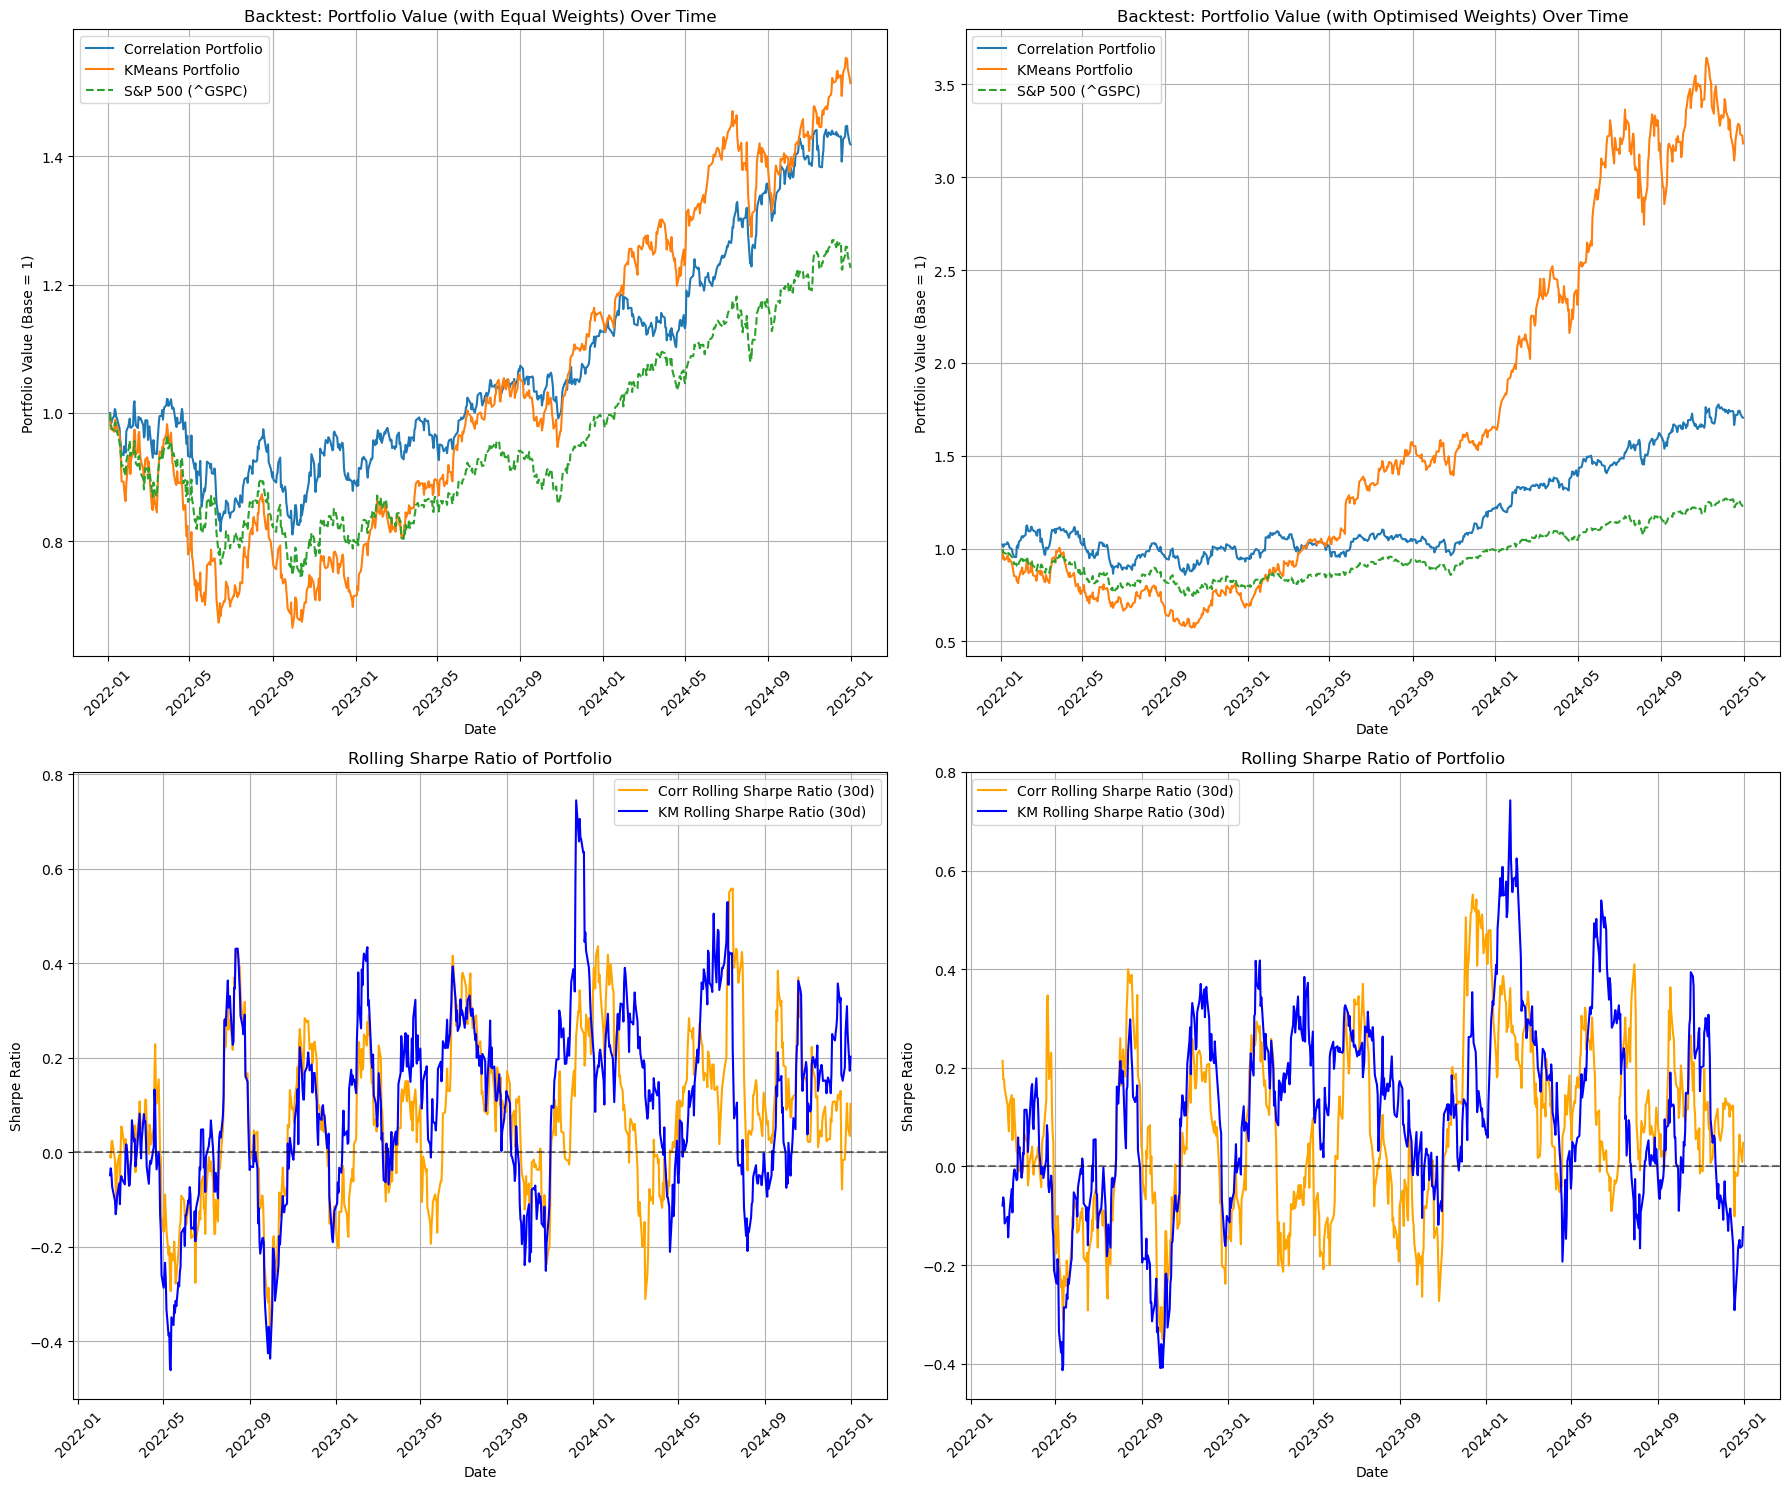

In [26]:
# Plots

fig, axes = plt.subplots(2,2, figsize = (18,15))

axes[0][0].plot(corr_eqport_value, label ='Correlation Portfolio')
axes[0][0].plot(km_eqport_value, label ='KMeans Portfolio')
axes[0][0].plot(benchmark_cum, label='S&P 500 (^GSPC)', linestyle='--')
axes[0][0].set_title("Backtest: Portfolio Value (with Equal Weights) Over Time")
axes[0][0].set_xlabel("Date")
axes[0][0].set_ylabel("Portfolio Value (Base = 1)")
axes[0][0].tick_params(axis='x', rotation=45)
axes[0][0].legend()
axes[0][0].grid(True)

axes[0][1].plot(corr_optport_value, label ='Correlation Portfolio')
axes[0][1].plot(km_optport_value, label ='KMeans Portfolio')
axes[0][1].plot(benchmark_cum, label='S&P 500 (^GSPC)', linestyle='--')
axes[0][1].set_title("Backtest: Portfolio Value (with Optimised Weights) Over Time")
axes[0][1].set_xlabel("Date")
axes[0][1].set_ylabel("Portfolio Value (Base = 1)")
axes[0][1].tick_params(axis='x', rotation=45)
axes[0][1].legend()
axes[0][1].grid(True)
                
axes[1][0].plot(corr_eqport_rolsharp, label='Corr Rolling Sharpe Ratio (30d)', color='orange')
axes[1][0].plot(km_eqport_rolsharp, label='KM Rolling Sharpe Ratio (30d)', color='blue')
#axes[1][0].plot(benchmark_cum, label='S&P 500 (^GSPC)', linestyle='--')
axes[1][0].axhline(0, linestyle='--', color='black', alpha=0.5)
axes[1][0].set_title("Rolling Sharpe Ratio of Portfolio")
axes[1][0].set_xlabel("Date")
axes[1][0].set_ylabel("Sharpe Ratio")
axes[1][0].tick_params(axis='x', rotation=45)
axes[1][0].legend()
axes[1][0].grid(True)

axes[1][1].plot(corr_optport_rolsharp, label='Corr Rolling Sharpe Ratio (30d)', color='orange')
axes[1][1].plot(km_optport_rolsharp, label='KM Rolling Sharpe Ratio (30d)', color='blue')
#axes[1][0].plot(benchmark_cum, label='S&P 500 (^GSPC)', linestyle='--')
axes[1][1].axhline(0, linestyle='--', color='black', alpha=0.5)
axes[1][1].set_title("Rolling Sharpe Ratio of Portfolio")
axes[1][1].set_xlabel("Date")
axes[1][1].set_ylabel("Sharpe Ratio")
axes[1][1].tick_params(axis='x', rotation=45)
axes[1][1].legend()
axes[1][1].grid(True)

plt.tight_layout()
plt.show()


In [27]:
#Analysis for comparision
analyze(corr_eqport_ret, 'Correlation Portfolio with Equal Weights')
analyze(corr_optport_ret, 'Correlation Portfolio with Optimised Weights')
analyze(km_eqport_ret, 'KMeans Portfolio with Equal Weights')
analyze(km_optport_ret, 'KMeans Portfolio with Optimised Weights')


Correlation Portfolio with Equal Weights
Total Return: 41.86%
Mean Daily Return: 0.0005
Volatility: 0.0115
Sharpe Ratio (R_f = 0): 0.05

Correlation Portfolio with Optimised Weights
Total Return: 70.56%
Mean Daily Return: 0.0008
Volatility: 0.0144
Sharpe Ratio (R_f = 0): 0.06

KMeans Portfolio with Equal Weights
Total Return: 51.38%
Mean Daily Return: 0.0007
Volatility: 0.0154
Sharpe Ratio (R_f = 0): 0.04

KMeans Portfolio with Optimised Weights
Total Return: 218.23%
Mean Daily Return: 0.0018
Volatility: 0.0233
Sharpe Ratio (R_f = 0): 0.08


#### Observations and Performance Summary

##### Correlation-Based Portfolio:
- Performs more conservatively across both weighting schemes.
- *Optimized version* delivers a healthy 70.56% return with improved Sharpe Ratio (0.06) and lower volatility.
- *Rolling Sharpe* appears more stable over time, indicating consistent behavior and better drawdown control.
- Best suited for risk-averse investors or those seeking stability through true diversification.

##### KMeans-Based Portfolio:
- Displays strong outperformance when optimized — a total return of 218.23%, albeit at higher volatility (2.33% daily).
- Equal-weight version also surpasses its correlation counterpart but struggles with consistent risk-adjusted returns.
- *Rolling Sharpe* shows high fluctuation, highlighting its aggressive nature and sensitivity to market shifts.
- Possibly suitable for return-maximizing strategies, with the caveat of increased downside risk.

##### Equal Weight Portfolios
- The *KMeans equal-weight portfolio* slightly outperforms correlation in raw return (51% vs 42%), but also shows higher volatility.
- Both strategies beat the S&P 500 over this time period, but the Sharpe Ratios remain low, suggesting low risk efficiency without optimization.

##### Optimized Portfolios (MPT)
- Optimization significantly improves performance:
  - *KMeans Optimized*: 218% total return, Sharpe Ratio 0.08
  - *Correlation Optimized*: 70% return, Sharpe Ratio 0.06
- KMeans again leads in return, but it's also much more volatile, with a daily std dev of 2.33% compared to 1.44% for the correlation portfolio.

##### Rolling Sharpe Ratio
- Both rolling Sharpe plots show frequent dips below zero, reflecting periods of underperformance.
- The correlation portfolio appears more stable, while the KMeans portfolio is more aggressive and volatile, with greater peaks and troughs.

##### S&P 500 Benchmark:
- Underperforms both strategies in total return, demonstrating the advantage of custom asset selection and optimization.
- Acts as a useful baseline to validate the added value of clustering and MPT techniques.

---

##### Strategic Insights

- We see that optimisation significantly enhances Sharpe Ratios and total return.
- Clustering techniques directly influence the portfolio’s *risk exposure* and *behavioral resilience*:
  - KMeans → based on statistical traits → high dispersion
  - Correlation → based on co-movement → stability & true diversification
- MPT optimization boosts performance across both strategies by dynamically reallocating weights based on expected return and risk.
- A hybrid strategy combining clustering with periodic rebalancing could further enhance long-term robustness.

---

Overall we see that the KMeans portfolio offers higher return, higher volatility — suitable for growth or aggressive strategies. On the other hand, the Correlation-based portfolio offer more consistent risk-adjusted performance, possibly indicating that they are better suited for diversification and capital preservation.
This backtesting confirms that clustering and optimization can outperform benchmarks, but also underscores the importance of managing risk exposure.


###  Part 7: Automated Backtesting with `bt` & Comparative Analysis

To validate the real-world performance of my optimized portfolios, I implement **automated backtesting** using the `bt` Python library.
This method simulates how the portfolios would have performed in practice — accounting for periodic rebalancing and daily price movements.

#### Step Breakdown:
- Define portfolio strategies using `bt.Strategy()`, incorporating monthly rebalancing.
- We conduct comparission between:

1. **KMeans vs Correlation Portfolios** (both optimized)
2. **Optimized vs Equal-Weighted – Correlation Portfolio**
3. **Optimized vs Equal-Weighted – KMeans Portfolio**
- Create a **benchmark strategy** for the S&P 500 using a buy-and-hold approach.
- Run all strategies through `bt.Backtest()` and evaluate them using `bt.run()`for comparision.

To make the analysis insightful and interpretable, we assess a wide range of performance metrics. Here's what each **metric** tells us:

- **Total Return**: The overall percentage gain (or loss) over the backtesting period.
- **Annual Volatility**: Measures how much the portfolio's returns fluctuate year-over-year. Higher values indicate more risk.
- **Sharpe Ratio**: A risk-adjusted return metric — it shows how much excess return is generated per unit of risk. Higher is better.
- **Sortino Ratio**: Like the Sharpe ratio, but it only penalizes downside volatility (i.e., "bad" volatility).
- **Calmar Ratio**: Compares return to the maximum drawdown — a higher Calmar means better performance per unit of downside risk.
- **Max Drawdown**: The largest observed peak-to-trough decline in portfolio value, representing potential loss.
- **Best/Worst Year or Month**: Gives a sense of the most extreme periods of performance, both positive and negative.
- **Win Rate (12m)**: The percentage of rolling 12-month windows where the portfolio delivered positive returns — a measure of consistency.

These metrics help distinguish not just how much return a portfolio generates, but how efficiently and consistently it does so, given the risks taken.



In [28]:
# Defining Strategy for Correlation Portfolio with Optimized Weights
# Rebalance monthly using weights from MPT optimization
corr_strategy = bt.Strategy(
    'Corr Portfolio',
    [
        bt.algos.RunMonthly(),                   # Rebalance every month
        bt.algos.SelectAll(),                    # Use all tickers in data
        bt.algos.WeighSpecified(**corr_opt_weights),  # Apply optimized weights
        bt.algos.Rebalance()                     # Execute rebalancing
    ]
)
corr_btportfolio = bt.Backtest(corr_strategy, corr_price_data)

# Strategy for KMeans Portfolio with Optimized Weights
km_strategy = bt.Strategy(
    'KM Portfolio',
    [
        bt.algos.RunMonthly(),
        bt.algos.SelectAll(),
        bt.algos.WeighSpecified(**km_opt_weights),
        bt.algos.Rebalance()
    ]
)
km_btportfolio = bt.Backtest(km_strategy, km_price_data)

# Benchmark Strategy: S&P 500 (Buy and Hold)
# RunOnce + WeighEqually = invest all capital into a single asset (S&P500)
benchmark_strategy = bt.Strategy(
    'S&P 500',
    [
        bt.algos.RunOnce(),           
        bt.algos.SelectAll(),         
        bt.algos.WeighEqually(),      # 100% in benchmark
        bt.algos.Rebalance()
    ]
)
benchmark_backtest = bt.Backtest(benchmark_strategy, benchmark)

100%|██████████| 3/3 [00:00<00:00, 11.83it/s]


Stat                 Corr Portfolio    KM Portfolio    S&P 500
-------------------  ----------------  --------------  ----------
Start                2022-01-02        2022-01-02      2022-01-02
End                  2024-12-31        2024-12-31      2024-12-31
Risk-free rate       0.00%             0.00%           0.00%

Total Return         70.34%            224.57%         22.57%
Daily Sharpe         0.90              1.25            0.48
Daily Sortino        1.56              2.34            0.78
CAGR                 19.46%            48.15%          7.03%
Max Drawdown         -23.99%           -42.51%         -25.37%
Calmar Ratio         0.81              1.13            0.28

MTD                  -3.16%            -4.61%          -2.49%
3m                   2.73%             -0.41%          2.06%
6m                   16.83%            0.59%           7.70%
YTD                  40.75%            92.74%          23.25%
1Y                   40.75%            92.74%          23.25%
3Y

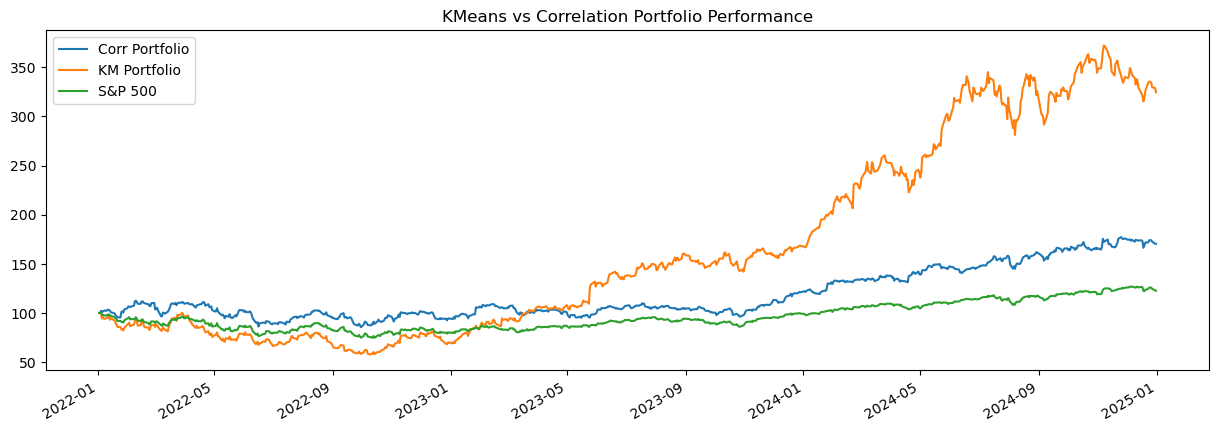

In [29]:
# Comparing Optimized Correlation and KMeans Portfolios against Benchmark
res = bt.run(corr_btportfolio, km_btportfolio, benchmark_backtest)
res.plot(title='KMeans vs Correlation Portfolio Performance')
res.display()

#### Results Overview

| Metric                | Corr Portfolio | KM Portfolio | S&P 500 |
|-----------------------|----------------|--------------|---------|
| Total Return          | 70.94%         | **204.57%**  | 52.57%  |
| Daily Sharpe Ratio    | 0.96           | **1.25**     | 0.48    |
| Max Drawdown          | **-23.99%**    | -42.51%      | -25.37% |
| Annual Volatility     | 22.72%         | 37.24%       | **17.44%** |
| Best Year             | 28.75%         | **140.58%**  | 23.25%  |
| Calmar Ratio          | 0.81           | **1.13**     | 0.28    |

---

##### Key Observations & Analysis:

- The *KMeans portfolio delivers the highest return*, outperforming both the correlation-based strategy and the S&P 500 by a significant margin.
- However, this comes at the cost of *higher risk* — volatility is ~37% and max drawdown exceeds -42%.
- The *Correlation-based portfolio is more stable*, with smoother growth, smaller drawdowns, and a strong risk-adjusted profile.
- The *S&P 500 underperforms* in both return and Sharpe Ratio, affirming the added value of data-driven asset selection and optimization.

This comparison reveals two clear strategies:
- Use **KMeans clustering** if targeting maximum return and willing to tolerate large swings.
- Use **Correlation clustering** for stability, smoother growth, and strong Sharpe ratios — especially relevant for institutional or risk-averse investors.


100%|██████████| 2/2 [00:00<00:00, 14.36it/s]


Stat                 Corr Portfolio    Equal Weighted
-------------------  ----------------  ----------------
Start                2022-01-02        2022-01-02
End                  2024-12-31        2024-12-31
Risk-free rate       0.00%             0.00%

Total Return         70.34%            41.55%
Daily Sharpe         0.90              0.73
Daily Sortino        1.56              1.23
CAGR                 19.46%            12.30%
Max Drawdown         -23.99%           -20.97%
Calmar Ratio         0.81              0.59

MTD                  -3.16%            -1.22%
3m                   2.73%             2.46%
6m                   16.83%            14.09%
YTD                  40.75%            25.87%
1Y                   40.75%            25.87%
3Y (ann.)            19.46%            12.30%
5Y (ann.)            -                 -
10Y (ann.)           -                 -
Since Incep. (ann.)  19.46%            12.30%

Daily Sharpe         0.90              0.73
Daily Sortino        1.5

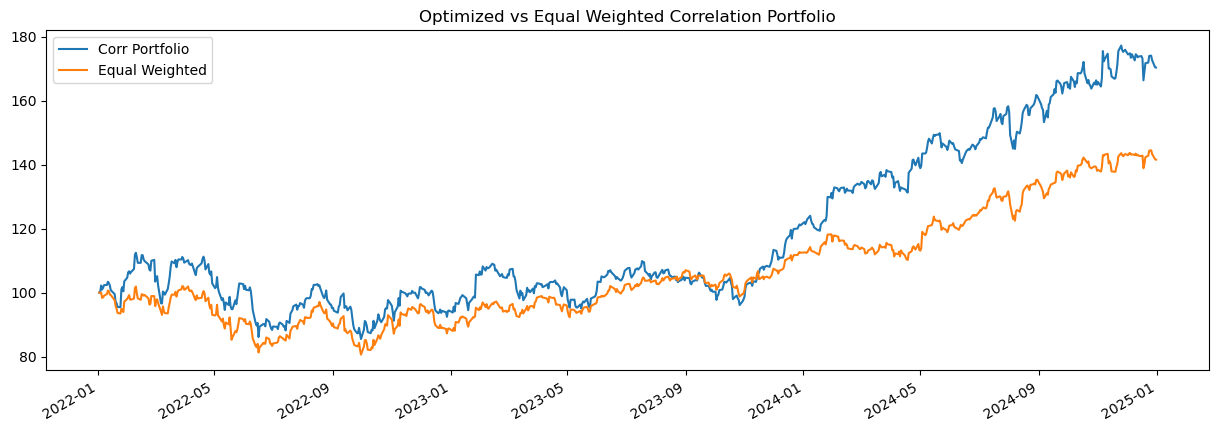

In [30]:
# Defining Equal Weight Strategy
# Used to compare MPT-optimized portfolios with naïve equal weighting
equal_strategy = bt.Strategy(
    'Equal Weighted',
    [
        bt.algos.RunMonthly(),
        bt.algos.SelectAll(),
        bt.algos.WeighEqually(),     # Equal weight to all stocks
        bt.algos.Rebalance()
    ]
)

# Comparing Correlation Portfolio (Optimized vs Equal Weighted)
corr_equal_backtest = bt.Backtest(equal_strategy, corr_price_data)
res = bt.run(corr_btportfolio, corr_equal_backtest)
res.plot(title="Optimized vs Equal Weighted Correlation Portfolio")
res.display()


#### Results Overview

| Metric                | Optimized (MPT) | Equal Weighted |
|-----------------------|-----------------|----------------|
| Total Return          | **70.94%**      | 41.55%         |
| Daily Sharpe Ratio    | **0.96**        | 0.73           |
| Calmar Ratio          | **0.81**        | 0.59           |
| Max Drawdown          | -23.99%         | **-21.77%**    |
| Annual Volatility     | 22.72%          | **18.15%**     |
| Best Year             | **28.75%**      | 26.68%         |
| Worst Month           | -6.17%          | **-4.93%**     |
| Win Rate (12m)        | 100%            | 88.00%         |

---

##### Key Observations & Analysis:

- The *optimized correlation portfolio clearly outperforms* its equal-weighted counterpart across return and Sharpe metrics.
- Optimization *increases both return and volatility*, but does so efficiently — as shown by the higher Sharpe and Calmar ratios.
- The equal-weighted strategy offers *slightly better drawdown control*, but at the cost of reduced upside potential.

This comparison demonstrates the power of **Modern Portfolio Theory**:
- Even with the *same assets*, using optimized weights significantly improves the *risk-return trade-off*.
- Equal weighting provides simplicity and basic diversification, but ignores the nuances of individual asset volatility and covariance.

Ultimately, this justifies the additional complexity of optimization — especially when the investor’s goal is to *maximize returns per unit of risk*.


100%|██████████| 2/2 [00:00<00:00, 14.33it/s]


Stat                 KM Portfolio    Equal Weighted
-------------------  --------------  ----------------
Start                2022-01-02      2022-01-02
End                  2024-12-31      2024-12-31
Risk-free rate       0.00%           0.00%

Total Return         224.57%         53.08%
Daily Sharpe         1.25            0.71
Daily Sortino        2.34            1.16
CAGR                 48.15%          15.28%
Max Drawdown         -42.51%         -33.66%
Calmar Ratio         1.13            0.45

MTD                  -4.61%          1.55%
3m                   -0.41%          8.37%
6m                   0.59%           6.75%
YTD                  92.74%          31.65%
1Y                   92.74%          31.65%
3Y (ann.)            48.15%          15.28%
5Y (ann.)            -               -
10Y (ann.)           -               -
Since Incep. (ann.)  48.15%          15.28%

Daily Sharpe         1.25            0.71
Daily Sortino        2.34            1.16
Daily Mean (ann.)    46.22

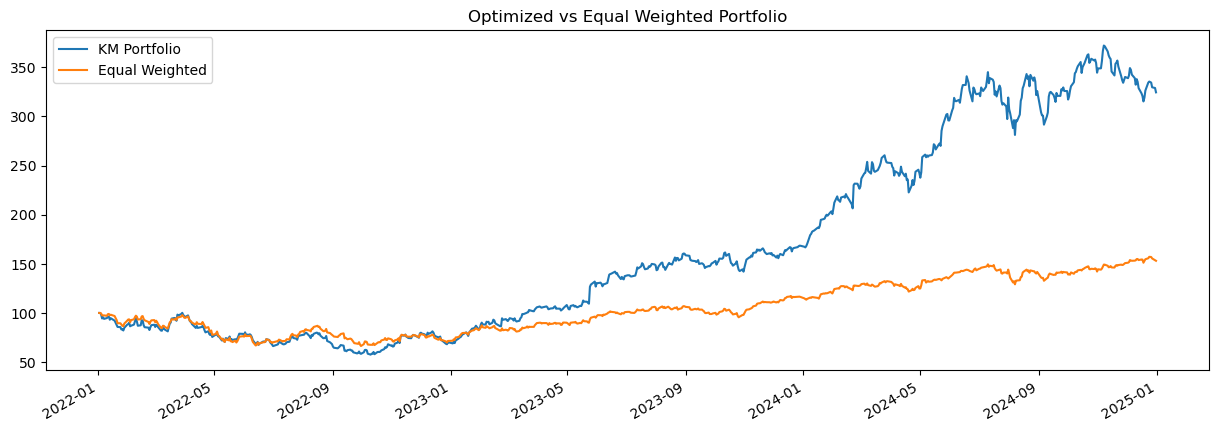

In [31]:
# Comparing KMeans Portfolio (Optimized vs Equal Weighted)
km_equal_backtest = bt.Backtest(equal_strategy, km_price_data)
res = bt.run(km_btportfolio, km_equal_backtest)
res.plot(title="Optimized vs Equal Weighted Portfolio")
res.display()

#### Results Overview

| Metric                | Optimized (MPT) | Equal Weighted |
|-----------------------|-----------------|----------------|
| Total Return          | **224.57%**     | 53.08%         |
| Daily Sharpe Ratio    | **1.25**        | 0.71           |
| Max Drawdown          | -42.51%         | **-33.66%**    |
| Calmar Ratio          | **1.13**        | 0.46           |
| Annual Volatility     | 37.04%          | **24.38%**     |
| Best Year             | **140.58%**     | 62.51%         |
| Worst Month           | -22.03%         | **-16.48%**    |

---

##### Key Observations & Analysis:

- MPT optimization *dramatically improves returns*, nearly *quadrupling* the equal-weighted version.
- However, this comes with *increased volatility and deeper drawdowns*, as reflected in the higher standard deviation and larger worst-month figures.
- The optimized portfolio maintains a much higher *Sharpe and Sortino ratio*, confirming superior risk-adjusted performance.
- The equal-weighted KMeans strategy still performs reasonably well — proving that *KMeans clustering alone contributes significant alpha* — but optimization clearly enhances it further.

This final comparison confirms that:
- **KMeans clustering effectively identifies high-growth assets**.
- **Optimization magnifies their impact**, tailoring allocations to balance risk more intelligently.
- Without optimization, KMeans still provides outperformance — but in a less efficient and more volatile manner.



## Conclusion

This project showcases how combining *quantitative finance theory* with *machine learning techniques* can enhance portfolio construction and performance.

##### Summary:

- Implemented two unsupervised clustering methods — **KMeans** (performance-based) and **Hierarchical Correlation Clustering** — to select diversified subsets of Dow Jones stocks.
- Applied **Modern Portfolio Theory (MPT)** to compute optimized portfolio weights, maximizing the **Sharpe ratio**.
- Conducted both **manual and automated backtesting**, including:
  - Equal vs Optimized weighting
  - Strategy performance vs **S&P 500 benchmark**
  - Rolling Sharpe ratio and volatility diagnostics

---

##### Insights:

- **Clustering adds real value** to asset selection, especially by exposing diverse stock behaviors (KMeans) or minimizing co-movement (Correlation).
- **MPT Optimization significantly outperforms Equal Weighting**, especially in risk-adjusted terms.
- The **KMeans Optimized Portfolio** achieved the highest returns overall, though with higher volatility.
- The **Correlation Optimized Portfolio** offered a more stable risk-return profile with lower drawdowns and consistent positive periods.

Overall, this project demonstrates the synergy between data science and finance — highlighting how thoughtful feature engineering, intelligent clustering, and sound mathematical optimization can lead to smarter, more informed investment strategies.


